# Employee Reviews

**Method 1 : TFIDF with Classifiers**

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score
import xgboost as xgb
import re
import string
import joblib

In [2]:
# Create directory

os.makedirs("./NLP",exist_ok=True)
print("Folder created")

Folder created


In [3]:
# Upload and move dataset

from google.colab import files
uploaded = files.upload()

Saving test_set.csv to test_set.csv
Saving train_set.csv to train_set.csv
Saving validation_set.csv to validation_set.csv


In [4]:
shutil.move("./train_set.csv","./NLP")
shutil.move("./test_set.csv","./NLP")
shutil.move("./validation_set.csv","./NLP")
print("Files copied to folder")

Files copied to folder


In [5]:
# Create dataframe

def create_dataframe(filepath):
  df = pd.read_csv(filepath)
  # Select relevant columns
  df = df[['nine_box_category','feedback','label','feedback_len','num_of_sent','performance_class','potential_class']]
  # check for null values
  print(df.isnull().sum())
  # drop null values
  df.dropna(inplace=True)
  print("\nNumber of records:",len(df))
  print()
  # Column types
  print(df.dtypes)
  return df

In [6]:
# Create train set

train = create_dataframe(r"/content/NLP/train_set.csv")
train.head()

nine_box_category    0
feedback             0
label                0
feedback_len         0
num_of_sent          0
performance_class    0
potential_class      0
dtype: int64

Number of records: 656

nine_box_category    object
feedback             object
label                 int64
feedback_len          int64
num_of_sent           int64
performance_class     int64
potential_class       int64
dtype: object


,nine_box_category,feedback,label,feedback_len,num_of_sent,performance_class,potential_class
0,"Category 1: 'Risk' (Low performance, Low poten...",John has not progressed in his position. He is...,0,287,5,0,0
1,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has been having trouble in all a...,0,430,6,0,0
2,"Category 1: 'Risk' (Low performance, Low poten...",Douglas has a lot to work on and areas to grow...,0,290,4,0,0
3,"Category 1: 'Risk' (Low performance, Low poten...","Freddie is a nice guy, but his performance and...",0,418,5,0,0
4,"Category 1: 'Risk' (Low performance, Low poten...",Freddie has been quite disappointing this quar...,0,449,4,0,0


In [7]:
# Create validation dataframe

val = create_dataframe(r"/content/NLP/validation_set.csv")
val.head()

nine_box_category    0
feedback             0
label                0
feedback_len         0
num_of_sent          0
performance_class    0
potential_class      0
dtype: int64

Number of records: 116

nine_box_category    object
feedback             object
label                 int64
feedback_len          int64
num_of_sent           int64
performance_class     int64
potential_class       int64
dtype: object


,nine_box_category,feedback,label,feedback_len,num_of_sent,performance_class,potential_class
0,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has not performed at a high leve...,0,321,4,0,0
1,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies onboarded the team a few months...,0,502,4,0,0
2,"Category 1: 'Risk' (Low performance, Low poten...",Freddie Davies needs lots of improvement in hi...,0,265,2,0,0
3,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is not doing so well. His work on a ...,0,226,4,0,0
4,"Category 1: 'Risk' (Low performance, Low poten...",Broderick is always such a wildcard to put in ...,0,514,4,0,0


In [8]:
# Concat the dataframes for Exploratory Data Analysis

df = pd.concat([train,val])
df.head()

,nine_box_category,feedback,label,feedback_len,num_of_sent,performance_class,potential_class
0,"Category 1: 'Risk' (Low performance, Low poten...",John has not progressed in his position. He is...,0,287,5,0,0
1,"Category 1: 'Risk' (Low performance, Low poten...",Douglas Henry has been having trouble in all a...,0,430,6,0,0
2,"Category 1: 'Risk' (Low performance, Low poten...",Douglas has a lot to work on and areas to grow...,0,290,4,0,0
3,"Category 1: 'Risk' (Low performance, Low poten...","Freddie is a nice guy, but his performance and...",0,418,5,0,0
4,"Category 1: 'Risk' (Low performance, Low poten...",Freddie has been quite disappointing this quar...,0,449,4,0,0


In [9]:
len(df)

772

Exploratory Data Analysis

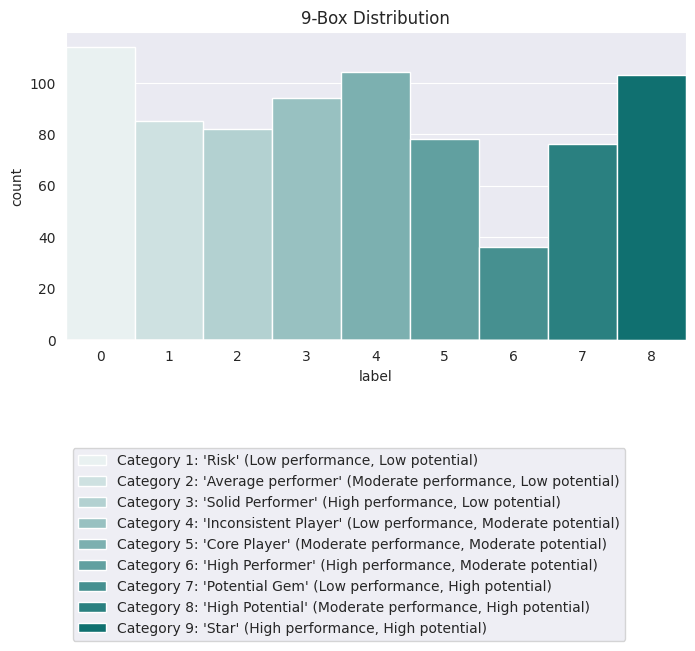

In [10]:
# Category distribution

fig = plt.figure(figsize=(8,4))
sns.set_style("darkgrid")
ax = sns.countplot(data=df,x='label',color='teal',hue='nine_box_category',width=1,dodge=False)
ax.set_title("9-Box Distribution")
ax.legend(loc="lower left",
          bbox_to_anchor=(0,-1))
plt.show()

In [11]:
df['label'].value_counts()

0    114
4    104
8    103
3     94
1     85
2     82
5     78
7     76
6     36
Name: label, dtype: int64

The labels are unbalanced

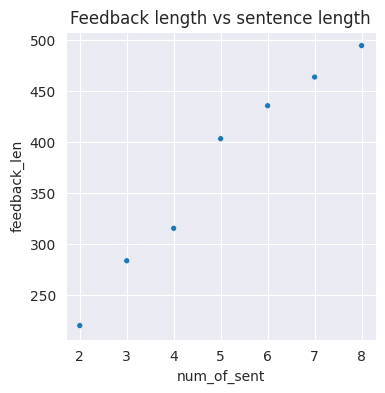

In [12]:
# Plot between sentence length and feedback length

df1 = df.groupby(by=['num_of_sent'],axis=0,as_index=False)['feedback_len'].mean()

fig = plt.figure(figsize=(4,4))
ax = sns.scatterplot(data=df1,x='num_of_sent',y="feedback_len",size=50)
ax.set_title("Feedback length vs sentence length")
ax.legend().set_visible(False)
plt.show()

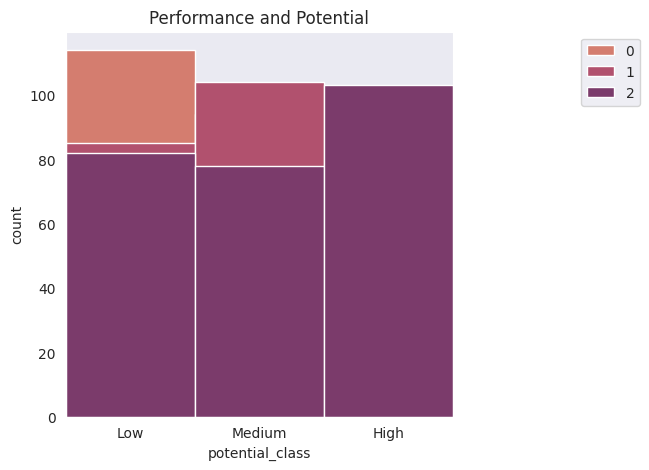

In [13]:
fig = plt.figure(figsize=(5,5))
sns.set_style("darkgrid")
ax = sns.countplot(data=df,x='potential_class',hue='performance_class',palette = "flare",width=1,dodge=False)
ax.set_title("Performance and Potential")
ax.set_xticklabels(['Low','Medium','High'])
ax.legend(loc="upper right",bbox_to_anchor=(1.5,1))
plt.show()

TFIDF Vectorization and Classifier

In [25]:
# Preprocessing

def preprocess_text(text):
  # convert to string
  text = str(text)
  # convert to lowercase
  text = text.lower()
  # remove special characters
  text = re.sub(r'[^\w ]+','',text)
  # remove punctuation
  text = text.translate(str.maketrans('','',string.punctuation))
  # remove digits if any
  text = re.sub(r'[\d]+','',text)
  # remove single letters if any
  text = ' '.join(word for word in text.split() if len(word)>1)
  # remove multiple spaces if any
  text = ' '.join(text.split())
  return text

In [26]:
# pre-process train

train_final = train.copy()
train_final.loc[:,'feedback'] = train_final['feedback'].apply(lambda x:preprocess_text(x))
train_final.head()

,nine_box_category,feedback,label,feedback_len,num_of_sent,performance_class,potential_class
0,"Category 1: 'Risk' (Low performance, Low poten...",john has not progressed in his position he is ...,0,287,5,0,0
1,"Category 1: 'Risk' (Low performance, Low poten...",douglas henry has been having trouble in all a...,0,430,6,0,0
2,"Category 1: 'Risk' (Low performance, Low poten...",douglas has lot to work on and areas to grow i...,0,290,4,0,0
3,"Category 1: 'Risk' (Low performance, Low poten...",freddie is nice guy but his performance and po...,0,418,5,0,0
4,"Category 1: 'Risk' (Low performance, Low poten...",freddie has been quite disappointing this quar...,0,449,4,0,0


In [27]:
# pre-process validation

val_final = val.copy()
val_final.loc[:,'feedback'] = val_final['feedback'].apply(lambda x:preprocess_text(x))
val_final.head()

,nine_box_category,feedback,label,feedback_len,num_of_sent,performance_class,potential_class
0,"Category 1: 'Risk' (Low performance, Low poten...",douglas henry has not performed at high level ...,0,321,4,0,0
1,"Category 1: 'Risk' (Low performance, Low poten...",freddie davies onboarded the team few months a...,0,502,4,0,0
2,"Category 1: 'Risk' (Low performance, Low poten...",freddie davies needs lots of improvement in hi...,0,265,2,0,0
3,"Category 1: 'Risk' (Low performance, Low poten...",broderick is not doing so well his work on dai...,0,226,4,0,0
4,"Category 1: 'Risk' (Low performance, Low poten...",broderick is always such wildcard to put in fr...,0,514,4,0,0


In [17]:
# Tfidf Vectorizer

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_final['feedback'])
val_tfidf = tfidf.transform(val_final['feedback'])
train_tfidf.shape,val_tfidf.shape

((656, 3465), (116, 3465))

In [18]:
# Class weights for unbalanced labels

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight("balanced",
                                     classes=np.unique(train_final['label']),
                                     y=train_final['label'])
class_weights_dict = {}
for label in list(np.unique(train_final['label'])):
  if label not in class_weights_dict:
    class_weights_dict[label] = round(class_weights[label],3)

class_weights_dict

{0: 0.751,
 1: 1.012,
 2: 1.041,
 3: 0.911,
 4: 0.828,
 5: 1.104,
 6: 2.351,
 7: 1.121,
 8: 0.838}

In [19]:
# Classifer 1: Random Forest Classifier

labels = list(train_final['label'])
model_rfc = RandomForestClassifier(n_estimators=300,class_weight=class_weights_dict)
model_rfc.fit(train_tfidf,labels)

# Check metrics
predictions = model_rfc.predict(val_tfidf)
print("Accuracy Score:",accuracy_score(val_final['label'],list(predictions)))
print()
print("\t\tClassification Report:\n\n",classification_report(val_final['label'],list(predictions),zero_division=0))

Accuracy Score: 0.3706896551724138

		Classification Report:

               precision    recall  f1-score   support

           0       0.43      0.88      0.58        17
           1       0.22      0.15      0.18        13
           2       0.25      0.08      0.12        12
           3       0.56      0.64      0.60        14
           4       0.25      0.25      0.25        16
           5       0.40      0.17      0.24        12
           6       0.00      0.00      0.00         5
           7       0.40      0.18      0.25        11
           8       0.32      0.50      0.39        16

    accuracy                           0.37       116
   macro avg       0.31      0.32      0.29       116
weighted avg       0.34      0.37      0.33       116



In [20]:
# Classifier 2 : Logistic Regression

labels = list(train_final['label'])
model_lr = LogisticRegression(solver='lbfgs')
model_lr.fit(train_tfidf,labels)

# Check metrics
predictions = model_lr.predict(val_tfidf)
print("Accuracy Score:",accuracy_score(val_final['label'],list(predictions)))
print()
print("\t\tClassification Report:\n\n",classification_report(val_final['label'],list(predictions),zero_division=0))

Accuracy Score: 0.4396551724137931

		Classification Report:

               precision    recall  f1-score   support

           0       0.52      0.88      0.65        17
           1       0.33      0.31      0.32        13
           2       0.50      0.33      0.40        12
           3       0.47      0.57      0.52        14
           4       0.26      0.31      0.29        16
           5       0.40      0.17      0.24        12
           6       0.00      0.00      0.00         5
           7       1.00      0.18      0.31        11
           8       0.46      0.69      0.55        16

    accuracy                           0.44       116
   macro avg       0.44      0.38      0.36       116
weighted avg       0.46      0.44      0.40       116



In [21]:
# Classifier 3 : Logistic Regression with CV

labels = list(train_final['label'])
model_lr_cv = LogisticRegressionCV(cv=5,solver='lbfgs',max_iter=500)
model_lr_cv.fit(train_tfidf,labels)

# Check metrics
predictions = model_lr_cv.predict(val_tfidf)
print("Accuracy Score:",accuracy_score(val_final['label'],list(predictions)))
print()
print("\t\tClassification Report:\n\n",classification_report(val_final['label'],list(predictions),zero_division=0))

Accuracy Score: 0.5

		Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.31      0.38      0.34        13
           2       0.50      0.42      0.45        12
           3       0.47      0.64      0.55        14
           4       0.33      0.38      0.35        16
           5       0.50      0.33      0.40        12
           6       0.50      0.20      0.29         5
           7       0.56      0.45      0.50        11
           8       0.59      0.62      0.61        16

    accuracy                           0.50       116
   macro avg       0.50      0.47      0.47       116
weighted avg       0.51      0.50      0.50       116



In [22]:
# Classfier 4 : XGBoost

labels = list(train_final['label'])
model_xgb = xgb.XGBClassifier(100)
model_xgb.fit(train_tfidf,labels)

# Check metrics
predictions = model_xgb.predict(val_tfidf)
print("Accuracy Score:",accuracy_score(val_final['label'],list(predictions)))
print()
print("\t\tClassification Report:\n\n",classification_report(val_final['label'],list(predictions),zero_division=0))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Accuracy Score: 0.3879310344827586

		Classification Report:

               precision    recall  f1-score   support

           0       0.50      0.71      0.59        17
           1       0.20      0.15      0.17        13
           2       0.40      0.33      0.36        12
           3       0.50      0.50      0.50        14
           4       0.33      0.38      0.35        16
           5       0.33      0.25      0.29        12
           6       1.00      0.20      0.33         5
           7       0.50      0.18      0.27        11
           8       0.31      0.50      0.38        16

    accuracy                           0.39       116
   macro avg       0.45      0.36      0.36       116
weighted avg       0.41      0.39      0.37       116



In [23]:
# Classifier 5: Multinomial NB

labels = list(train_final['label'])
model_mnb = MultinomialNB()
model_mnb.fit(train_tfidf,labels)

# Check metrics
predictions = model_mnb.predict(val_tfidf)
print("Accuracy Score:",accuracy_score(val_final['label'],list(predictions)))
print()
print("\t\tClassification Report:\n\n",classification_report(val_final['label'],list(predictions),zero_division=0))

Accuracy Score: 0.3793103448275862

		Classification Report:

               precision    recall  f1-score   support

           0       0.37      1.00      0.54        17
           1       0.50      0.08      0.13        13
           2       0.00      0.00      0.00        12
           3       0.62      0.36      0.45        14
           4       0.24      0.56      0.34        16
           5       1.00      0.08      0.15        12
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        11
           8       0.52      0.69      0.59        16

    accuracy                           0.38       116
   macro avg       0.36      0.31      0.25       116
weighted avg       0.39      0.38      0.29       116



**Method 2: Deep Learning**

In [23]:
import tensorflow as tf
from keras.layers import Input,Dense,Embedding,Flatten
from keras.layers import Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D
from keras.layers import LSTM,GRU,Bidirectional,BatchNormalization
from keras.regularizers import l2
from keras.models import Model,Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [28]:
# Tokenize data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_final['feedback'])
len(tokenizer.word_counts)

3465

In [30]:
# Create sequences
train_sequences = tokenizer.texts_to_sequences(train_final['feedback'])
val_sequences = tokenizer.texts_to_sequences(val_final['feedback'])

In [31]:
# Max length of sequence

max_length = max([len(seq) for seq in train_sequences])
max_length

104

In [29]:
y_train = to_categorical(list(train_final['label']),num_classes=9)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [32]:
# Pad sequences

X_train = pad_sequences(train_sequences,maxlen=max_length,padding='post')
y_train = to_categorical(list(train_final['label']),num_classes=9)

X_test = pad_sequences(val_sequences,maxlen=max_length,padding='post')
y_test = to_categorical(list(val_final['label']),num_classes=9)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(656, 104) (656, 9)
(116, 104) (116, 9)


In [33]:
num_labels = y_train.shape[1]
num_labels

9

CNN

In [34]:
# Build Model

vocab_size = len(tokenizer.word_counts) + 1
vector_len = 100

model = Sequential()
model.add(Embedding(vocab_size,vector_len,input_length=max_length))
model.add(Conv1D(32,2,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(32,2,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(32,2,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(9,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 100)          346600    
                                                                 
 conv1d (Conv1D)             (None, 103, 32)           6432      
                                                                 
 batch_normalization (BatchN  (None, 103, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 51, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            2080      
                                                                 
 batch_normalization_1 (Batc  (None, 50, 32)           1

In [35]:
# Compile
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.fit(X_train,y_train,epochs=10,batch_size=2,validation_data=(X_test,y_test))

Epoch 1/10
328/328 [==============================] - 5s 9ms/step - loss: 2.3045 - accuracy: 0.1204 - val_loss: 2.2531 - val_accuracy: 0.0948
Epoch 2/10
328/328 [==============================] - 3s 9ms/step - loss: 1.8273 - accuracy: 0.3643 - val_loss: 2.2365 - val_accuracy: 0.1034
Epoch 3/10
328/328 [==============================] - 4s 11ms/step - loss: 1.2954 - accuracy: 0.5640 - val_loss: 2.5704 - val_accuracy: 0.1724
Epoch 4/10
328/328 [==============================] - 3s 8ms/step - loss: 0.6906 - accuracy: 0.7881 - val_loss: 2.5795 - val_accuracy: 0.1638
Epoch 5/10
328/328 [==============================] - 3s 8ms/step - loss: 0.2618 - accuracy: 0.9375 - val_loss: 3.5605 - val_accuracy: 0.1466
Epoch 6/10
328/328 [==============================] - 3s 8ms/step - loss: 0.1045 - accuracy: 0.9909 - val_loss: 3.0439 - val_accuracy: 0.1724
Epoch 7/10
328/328 [==============================] - 4s 12ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 2.9145 - val_accuracy: 0.1724
Epoc

LSTM

In [36]:
# Build model

def build_model():
  sequences = Input(shape=(max_length,))
  embedding = Embedding(vocab_size,vector_len)(sequences)
  x = Bidirectional(LSTM(64,return_sequences=True))(embedding)
  x = BatchNormalization()(x)
  x = Bidirectional(LSTM(64))(x)
  x = BatchNormalization()(x)
  x = Dense(32,activation="relu")(x)
  predictions = Dense(9,activation="softmax")(x)
  model = Model(inputs = sequences,outputs = predictions)
  model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")
  return model

In [37]:
model = build_model()
model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
21/21 [==============================] - 18s 439ms/step - loss: 2.2939 - accuracy: 0.1601 - val_loss: 2.1875 - val_accuracy: 0.1379
Epoch 2/10
21/21 [==============================] - 8s 366ms/step - loss: 1.2247 - accuracy: 0.6966 - val_loss: 2.1730 - val_accuracy: 0.2500
Epoch 3/10
21/21 [==============================] - 6s 301ms/step - loss: 0.6119 - accuracy: 0.8933 - val_loss: 2.1636 - val_accuracy: 0.1466
Epoch 4/10
21/21 [==============================] - 9s 456ms/step - loss: 0.2670 - accuracy: 0.9726 - val_loss: 2.1559 - val_accuracy: 0.1379
Epoch 5/10
21/21 [==============================] - 6s 294ms/step - loss: 0.1040 - accuracy: 0.9970 - val_loss: 2.1503 - val_accuracy: 0.1379
Epoch 6/10
21/21 [==============================] - 8s 363ms/step - loss: 0.0510 - accuracy: 1.0000 - val_loss: 2.1457 - val_accuracy: 0.1379
Epoch 7/10
21/21 [==============================] - 7s 325ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 2.1415 - val_accuracy: 0.1379
Epoch

**Method 3: Transformers**

In [8]:
!pip install transformers datasets xformers torchinfo accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.3 MB/s eta 0:00:00


In [9]:
# Select relevant columns and save to file
def select_columns(df,name):
  df = df[["feedback","label"]]
  return df.to_csv(os.path.join("/content/NLP/",name+".csv"),index=None)

select_columns(train,'train')
select_columns(val,'val')

In [10]:
# Convert dataset format

from datasets import load_dataset
def convert_format(datapath):
  dataset = load_dataset("csv",data_files=datapath)
  return dataset

train_dataset = convert_format("/content/NLP/train.csv")
val_dataset = convert_format("/content/NLP/val.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9b52449854506afe/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-bc0ad777e7b8dcaa/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['feedback', 'label'],
        num_rows: 656
    })
})

In [12]:
val_dataset

DatasetDict({
    train: Dataset({
        features: ['feedback', 'label'],
        num_rows: 116
    })
})

In [13]:
# Define tokenizer
checkpoint = "distilbert-base-cased"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
# Create function for tokenizing
def tokenize_fn(batch):
  return tokenizer(batch['feedback'],truncation=True)

In [15]:
# Tokenize

tokenized_train = train_dataset.map(tokenize_fn)
tokenized_train

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['feedback', 'label', 'input_ids', 'attention_mask'],
        num_rows: 656
    })
})

In [16]:
tokenized_val = val_dataset.map(tokenize_fn)
tokenized_val

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['feedback', 'label', 'input_ids', 'attention_mask'],
        num_rows: 116
    })
})

In [17]:
# Dynamic Padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
# Define Model

from transformers import AutoModelForSequenceClassification,Trainer,TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=9)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.w

In [19]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           6,921
├─Dropout: 1-4                                          --
Total params: 65,788,425
Trainable params: 65,788,425
Non-trainable params: 0

In [20]:
# Creating training arguments

training_args = TrainingArguments(output_dir="training_dir",evaluation_strategy="epoch")

In [21]:
# Create metrics function

import evaluate
def compute_metrics(eval_preds):
  logits,labels = eval_preds
  predictions = np.argmax(logits,axis=-1)
  acc = np.mean(predictions==labels)
  f1 = f1_score(labels,predictions,average="macro")
  return ({"accuracy":acc,"f1":f1})

In [22]:
# Define trainer

trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_train['train'],
                  eval_dataset = tokenized_val['train'],
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.778662,0.310345,0.154526
2,No log,1.539449,0.448276,0.326116
3,No log,1.391359,0.551724,0.491836


TrainOutput(global_step=246, training_loss=1.6610609845417301, metrics={'train_runtime': 24.1649, 'train_samples_per_second': 81.441, 'train_steps_per_second': 10.18, 'total_flos': 54575101069632.0, 'train_loss': 1.6610609845417301, 'epoch': 3.0})

In [43]:
# Predictions on test set

test = pd.read_csv(r"/content/NLP/test_set.csv")
test.head(2)

,id,person_name,nine_box_category,feedback,updated,reviewed,label,performance_class,potential_class,feedback_clean
0,20051,Lacey Howard,"Category 1: 'Risk' (Low performance, Low poten...",Lacey's performance has been sub standard in t...,True,True,0,0,0,laceys performance ha been sub standard in the...
1,20214,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",Jon Fischer has not been instrumental so far a...,False,True,0,0,0,jon fischer ha not been instrumental so far at...


In [44]:
# pre-process test

test_final = test.copy()
test_final.loc[:,'feedback'] = test_final['feedback'].apply(lambda x:preprocess_text(x))
test_final.head(2)

,id,person_name,nine_box_category,feedback,updated,reviewed,label,performance_class,potential_class,feedback_clean
0,20051,Lacey Howard,"Category 1: 'Risk' (Low performance, Low poten...",laceys performance has been sub standard in th...,True,True,0,0,0,laceys performance ha been sub standard in the...
1,20214,Jon Fischer,"Category 1: 'Risk' (Low performance, Low poten...",jon fischer has not been instrumental so far a...,False,True,0,0,0,jon fischer ha not been instrumental so far at...


In [45]:
# Select relevant columns and save to file
select_columns(test_final,'test')

In [46]:
# Convert dataset format
test_dataset = convert_format("/content/NLP/test.csv")
test_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0cbcd0d3f5e1f512/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['feedback', 'label'],
        num_rows: 225
    })
})

In [47]:
# Tokenize

tokenized_test = test_dataset.map(tokenize_fn)
tokenized_test

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['feedback', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 225
    })
})

In [60]:
predictions = trainer.predict(tokenized_test['train'])
predictions

PredictionOutput(predictions=array([[ 1.8456455 ,  1.0795968 , -0.43290958, ...,  0.515759  ,
        -1.3503717 , -1.5771359 ],
       [ 2.39923   ,  0.88402724, -0.44063777, ...,  0.1539471 ,
        -1.3080841 , -1.5678009 ],
       [ 3.3210835 , -0.17677689, -0.65322536, ..., -0.57257056,
        -1.1793313 , -1.1828002 ],
       ...,
       [-1.9081197 , -1.2652787 , -0.07157697, ..., -1.5456676 ,
         1.389058  ,  1.878186  ],
       [-1.6939058 , -1.2956662 , -0.23596129, ..., -1.4305729 ,
         1.4408653 ,  2.0618107 ],
       [-1.415323  , -1.2233608 , -0.31516257, ..., -1.3846731 ,
         1.1776745 ,  2.4028416 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [65]:
predictions[0].shape

(225, 9)

In [66]:
y_pred =np.argmax(predictions[0],axis=-1)
y_pred[:10]

array([3, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [67]:
print("Accuracy Score:",accuracy_score(test_final['label'],y_pred))

Accuracy Score: 0.39555555555555555
